# Raspberry Pi Camera Capture of Rubik's Cube State

First we import the libraries we need and initialize a camera 'object.'

In [ ]:
from picamera import PiCamera
from picamera.color import Color

In [1]:
import os
from time import sleep

In [4]:
# import a bunch of stuff that we'll use to manipulate our images...
from skimage.io import imread
#from skimage import filter
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import block_reduce
import numpy as np

In [49]:
from sklearn.cluster import KMeans
import pandas as pd

In [218]:
import kociemba

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

In [75]:
camera = PiCamera()

In [76]:
camera.resolution = (120, 120)

camera.hflip = True
camera.vflip = True
camera.brightness = 70 # the default is 50, but you can set it to whatever.

How about some text on the image.

In [36]:
camera.annotate_foreground = Color(1.0,1.0,0.5)

camera.annotate_text = ""
camera.annotate_text_size = 36

In [80]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeU.jpg')
camera.stop_preview()

In [81]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeR.jpg')
camera.stop_preview()

In [82]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeF.jpg')
camera.stop_preview()

In [83]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeD.jpg')
camera.stop_preview()

In [84]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeL.jpg')
camera.stop_preview()

In [85]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeB.jpg')
camera.stop_preview()

In [86]:
camera.close()

## Now process the images...

In [177]:
face_order = 'URFDLB'

In [196]:
face_images = {}
face_images_out = []
squares = {}
masks = {}  # for QA

In [197]:
for face in face_order:
    # read and cache images in dict
    face_images[face] = (imread('./img/cube%s.jpg' % face))

    img = face_images[face]
    mask = np.empty(img.shape[:2], dtype=np.bool)
    mask[::]=False
    row_coords = [(25, 30), (50, 55), (75, 80)]
    col_coords = [(38, 43), (65, 70), (95, 100)]
    squares[face] = np.zeros((3, 3, 3))
    row = 0
    # extract average RGB values from approximate square centers
    for i in row_coords:
        col = 0
        for j in col_coords:
            mask[i[0]:i[1], j[0]:j[1]] = True
            squares[face][row, col] = (np.average(img[i[0]:i[1], j[0]:j[1], 0]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 1]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 2]))
            col+=1
        row+=1
    # to show last image alignment
    masks[face] = mark_boundaries(img, mask)

(-0.5, 119.5, 119.5, -0.5)

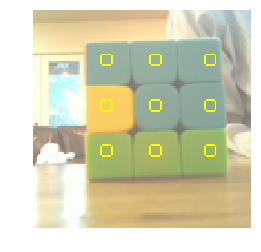

In [203]:
fig_mask = plt.figure()
ax = fig_mask.add_subplot(1,1,1)
ax.imshow(masks['F'])
plt.axis("off")

In [204]:
square_list = []
for face in face_order:
    for x in range(3):
        for y in range(3):
            r, g, b = squares[face][x,y]
            square_list.append([face, x, y, r, g, b])

columns = ['face', 'x', 'y', 'r', 'g', 'b']
square_frame = pd.DataFrame(square_list, columns=columns)

In [205]:
square_frame.head(10)

,face,x,y,r,g,b
0,U,0,0,242.96,211.28,163.72
1,U,0,1,238.52,211.76,162.64
2,U,0,2,238.52,208.04,164.60
3,U,1,0,248.88,205.88,162.92
4,U,1,1,244.68,204.08,158.64
5,U,1,2,243.52,203.76,161.12
6,U,2,0,239.60,201.04,157.16
7,U,2,1,234.88,198.72,153.64
8,U,2,2,233.20,197.20,155.40
9,R,0,0,252.64,155.24,125.64


In [206]:
X = square_frame[['r', 'g', 'b']]

In [207]:
km = KMeans(n_clusters=6, random_state=123)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [208]:
km.cluster_centers_

array([[ 160.52444444,  186.16      ,  106.67555556],
       [ 248.77333333,  150.98666667,  122.68444444],
       [ 229.64888889,  204.07555556,   98.49333333],
       [ 240.52888889,  204.64      ,  159.98222222],
       [ 143.97333333,  169.91111111,  157.04      ],
       [ 235.36444444,  119.16      ,  129.17333333]])

In [209]:
palette = np.zeros((100,600,3))
#print list(reversed([int(x) for x in km.cluster_centers_[0]]))
palette[0:99,0:99] = list(([int(x) for x in km.cluster_centers_[0]]))
palette[0:99,100:199] = list(([int(x) for x in km.cluster_centers_[1]]))
palette[0:99,200:299] = list(([int(x) for x in km.cluster_centers_[2]]))
palette[0:99,300:399] = list(([int(x) for x in km.cluster_centers_[3]]))
palette[0:99,400:499] = list(([int(x) for x in km.cluster_centers_[4]]))
palette[0:99,500:599] = list(([int(x) for x in km.cluster_centers_[5]]))

In [210]:
centers_list = []
center_rgb = square_frame[(square_frame['x']==1) & (square_frame['y']==1)]
print center_rgb

   face  x  y       r       g       b
4     U  1  1  244.68  204.08  158.64
13    R  1  1  250.88  145.24  120.76
22    F  1  1  146.64  169.72  155.28
31    D  1  1  241.08  210.12   98.60
40    L  1  1  238.68  113.56  128.80
49    B  1  1  159.24  187.16  104.36


In [211]:
square_mapper = {}
center_map = km.predict(center_rgb[['r', 'g', 'b']])
for i in range(6):
    square_mapper[center_map[i]] = face_order[i]

In [212]:
center_map

array([3, 1, 4, 2, 5, 0], dtype=int32)

In [213]:
square_mapper

{0: 'B', 1: 'R', 2: 'D', 3: 'U', 4: 'F', 5: 'L'}

In [214]:
square_predict = km.predict(square_frame[['r', 'g', 'b']])

In [215]:
squares = []
for square in square_predict:
    squares.append(square_mapper[square])

In [217]:
cube = ''.join(squares)

## Solve it!

In [220]:
solution = kociemba.solve(cube)

In [222]:
len(solution.split(' '))

19

In [223]:
solution

u"F L2 F U L D' F2 D L' B2 U' R2 U' F2 U L2 D F2 D"

(-0.5, 599.5, 99.5, -0.5)

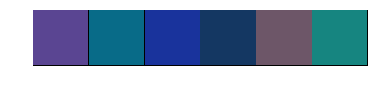

In [117]:
fig_pal = plt.figure()
ax = fig_pal.add_subplot(1,1,1)
ax.imshow(palette)
plt.axis("off")

In [87]:
print face_images['U'].shape
face_images['U']

(120, 120, 3)


array([[[201, 192, 153],
        [199, 192, 150],
        [200, 193, 149],
        ..., 
        [186, 220, 230],
        [179, 213, 225],
        [175, 209, 221]],

       [[200, 192, 155],
        [200, 192, 153],
        [200, 193, 151],
        ..., 
        [186, 223, 232],
        [178, 216, 225],
        [182, 220, 229]],

       [[198, 193, 153],
        [201, 194, 152],
        [202, 193, 152],
        ..., 
        [181, 219, 228],
        [178, 221, 228],
        [176, 219, 226]],

       ..., 
       [[243, 254, 250],
        [238, 252, 239],
        [231, 245, 220],
        ..., 
        [200, 188, 136],
        [201, 188, 136],
        [199, 186, 134]],

       [[238, 254, 251],
        [234, 250, 239],
        [228, 240, 216],
        ..., 
        [198, 186, 134],
        [197, 185, 133],
        [197, 185, 133]],

       [[233, 252, 248],
        [228, 244, 234],
        [227, 236, 215],
        ..., 
        [195, 183, 131],
        [194, 182, 130],
        [195, 183,

In [77]:
for img in face_images.itervalues():
    image = img_as_float(img)
    segments = slic(image, n_segments=2, sigma=5)
    face_images_out.append(segments)
 

In [78]:
print segments.shape

(120, 120)


(-0.5, 119.5, 119.5, -0.5)

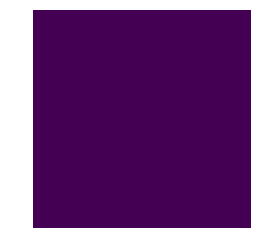

In [80]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_images_out[2])
plt.axis("off")

In [109]:
marked_img = mark_boundaries(face_images[2], face_images_out[2])

(-0.5, 719.5, 479.5, -0.5)

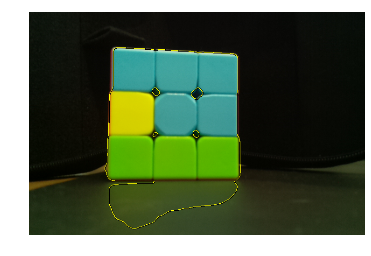

In [110]:
fig2 = plt.figure()
ax = fig2.add_subplot(1, 1, 1)
ax.imshow(marked_img)
plt.axis("off")

How about taking several shots...

In [29]:
camera.start_preview()
for i in range(5):
    sleep(3)
    camera.capture('./img/image%s.jpg' % i)
camera.stop_preview()

## What about video?

In [4]:
camera.start_preview()
camera.start_recording('img/videoday3.h264')
sleep(7)
camera.stop_recording()
camera.stop_preview()

This did generate a file, but the default format isn't playable through the browser, so...
Note: this did require the installation of gpac with:

*sudo apt-get install -y gpac*

In [33]:
# convert the video above to something playable through the browser, then delete the original unplayable version.
os.system("MP4Box -fps 30 -add img/videoday3.h264 img/videoday3.mp4")
os.remove("img/videoday3.h264")

When we're all finished with the camera module, it's a good idea to *close* the object to prevent GPU memory leakage.

In [13]:
camera.close()